In [240]:
# imports
import pandas as pd
import altair as alt
import json
import geopandas as gpd
import basedosdados as bd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns

In [241]:
# load election data (tse)
detalhes_votacao_municipio = bd.read_table(dataset_id='br_tse_eleicoes',
                    table_id='detalhes_votacao_municipio',
                    billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 320628/320628 [01:33<00:00, 3420.56rows/s]


In [242]:
# load geometry data (ibre)
municipio_geometry = bd.read_table(dataset_id='br_geobr_mapas',
                table_id='municipio',
                billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 5567/5567 [01:16<00:00, 72.68rows/s]


In [243]:
# get rows where cargo is "PRESIDENTE" and uf is valid
election_2018 = detalhes_votacao_municipio.query("cargo == 'presidente' & ano == 2018 & sigla_uf != 'ZZ'",)
election_2018

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,aptos,secoes,secoes_agregadas,...,comparecimento,abstencoes,votos_validos,votos_brancos,votos_nulos,votos_legenda,proporcao_comparecimento,proporcao_votos_validos,proporcao_votos_brancos,proporcao_votos_nulos
60795,2018,1,eleicao ordinaria,RO,1100015,310,presidente,18773,72,5,...,13435,5338,12691,228,516,0,71.565544,94.462227,1.697060,3.840714
60800,2018,1,eleicao ordinaria,RO,1100023,78,presidente,66840,249,11,...,50695,16145,48048,850,1797,0,75.845299,94.778580,1.676694,3.544728
60805,2018,1,eleicao ordinaria,RO,1100031,450,presidente,4611,19,5,...,3615,996,3406,61,148,0,78.399483,94.218536,1.687414,4.094053
60810,2018,1,eleicao ordinaria,RO,1100049,94,presidente,60857,230,13,...,49900,10957,47345,860,1695,0,81.995499,94.879761,1.723447,3.396794
60815,2018,1,eleicao ordinaria,RO,1100056,272,presidente,12232,49,12,...,10122,2110,9658,126,338,0,82.750160,95.415924,1.244813,3.339261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315780,2018,2,eleicao ordinaria,BA,2933307,39659,presidente,221857,653,87,...,191445,30412,173514,3071,14860,0,86.292068,90.633865,1.604116,7.762021
315781,2018,2,eleicao ordinaria,BA,2933406,39675,presidente,7193,22,5,...,4821,2372,4542,38,241,0,67.023499,94.212822,0.788218,4.998963
315782,2018,2,eleicao ordinaria,BA,2933455,39993,presidente,10194,34,3,...,7351,2843,7058,55,238,0,72.111046,96.014145,0.748197,3.237655
315783,2018,2,eleicao ordinaria,BA,2933505,39691,presidente,15572,45,5,...,11395,4177,10627,133,635,0,73.176216,93.260201,1.167179,5.572619


In [244]:
# get municipio where state is RJ
municipio_geometry_sudeste = municipio_geometry.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG']")
#municipio_geometry_rj = municipio_geometry
municipio_geometry_sudeste = pd.merge(municipio_geometry_sudeste, election_2018, on='id_municipio', how = 'inner')


In [245]:
municipio_geometry_sudeste['geometria'] = municipio_geometry_sudeste['geometria'].apply(wkt.loads)
municipio_geometry_sudeste_gpd = gpd.GeoDataFrame(municipio_geometry_sudeste, geometry='geometria')
municipio_geometry_sudeste_gpd['proporcao_brancos_nulos'] = municipio_geometry_sudeste_gpd['proporcao_votos_brancos'] + municipio_geometry_sudeste_gpd['proporcao_votos_nulos']


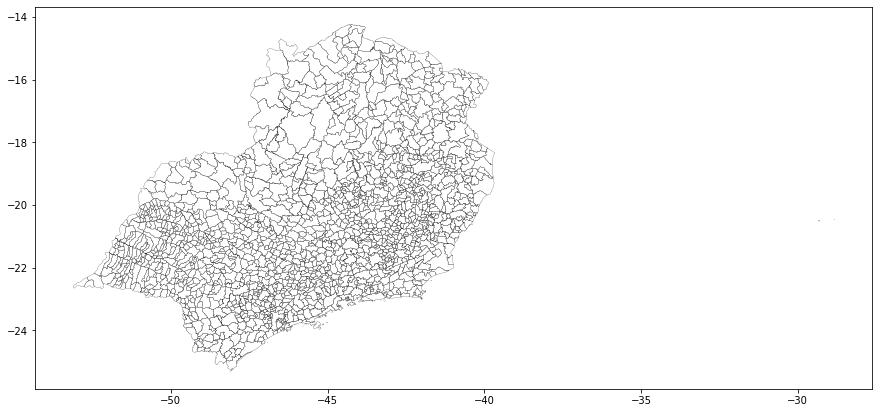

In [246]:
# testando geometrias
ax = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (15, 15), edgecolor = 'black', linewidth = 0.1)

In [247]:
# filtros turno
flt1 = ((municipio_geometry_sudeste_gpd['turno'] == 1))
flt2 = ((municipio_geometry_sudeste_gpd['turno'] == 2))


## Análise brancos e nulos

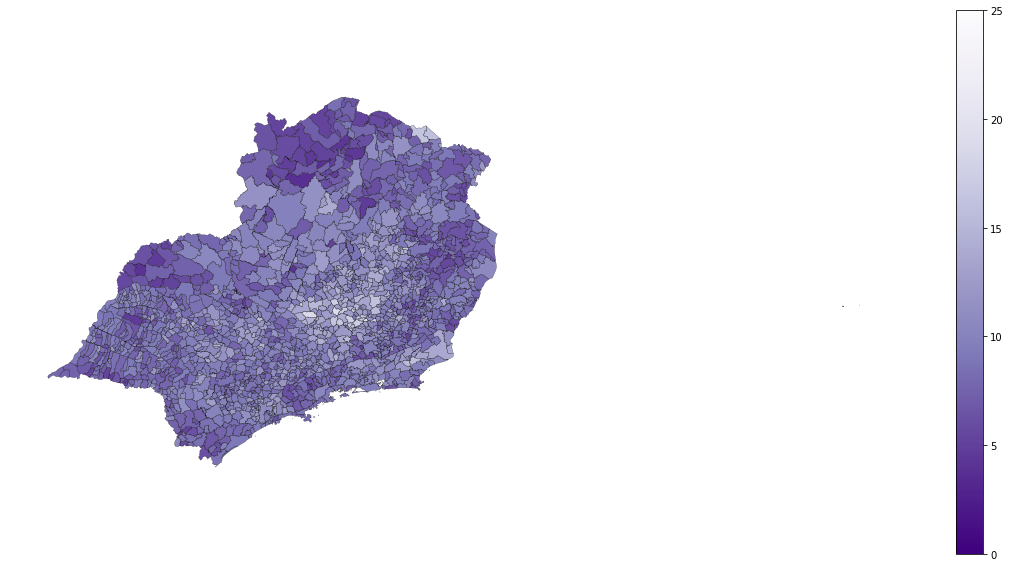

In [248]:
# proporcao brancos e nulos 1º turno

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt1].plot(column = 'proporcao_brancos_nulos',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples_r',
                                        vmin = 0,
                                        vmax = 25
                                        )
ax.set_axis_off()
plt.show()

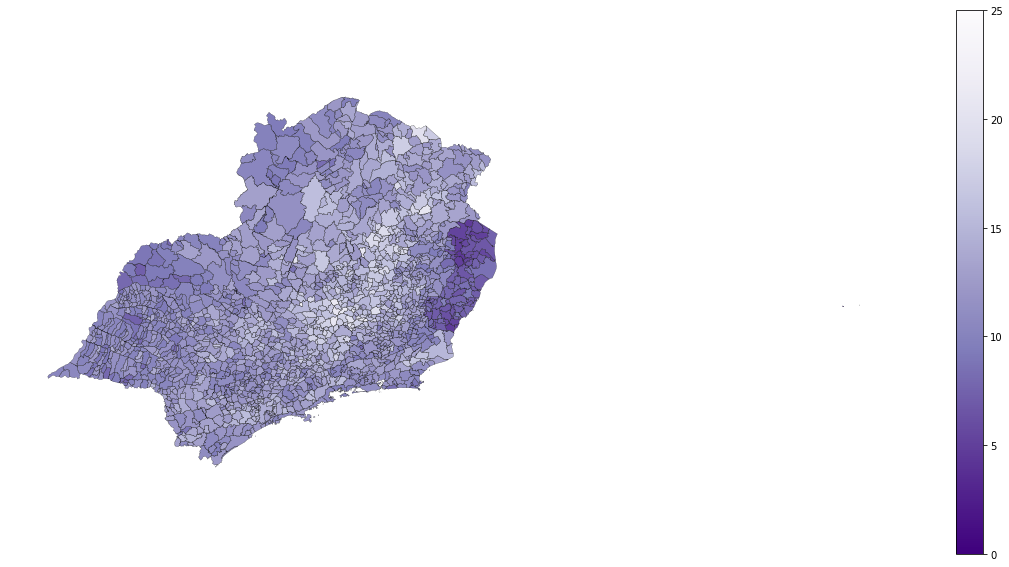

In [249]:
# proporcao brancos e nulos 2º turno

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt2].plot(column = 'proporcao_brancos_nulos',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples_r',
                                        vmin = 0,
                                        vmax = 25
                                        )

ax.set_axis_off()
plt.show()


## Análise a respeito de abstenções

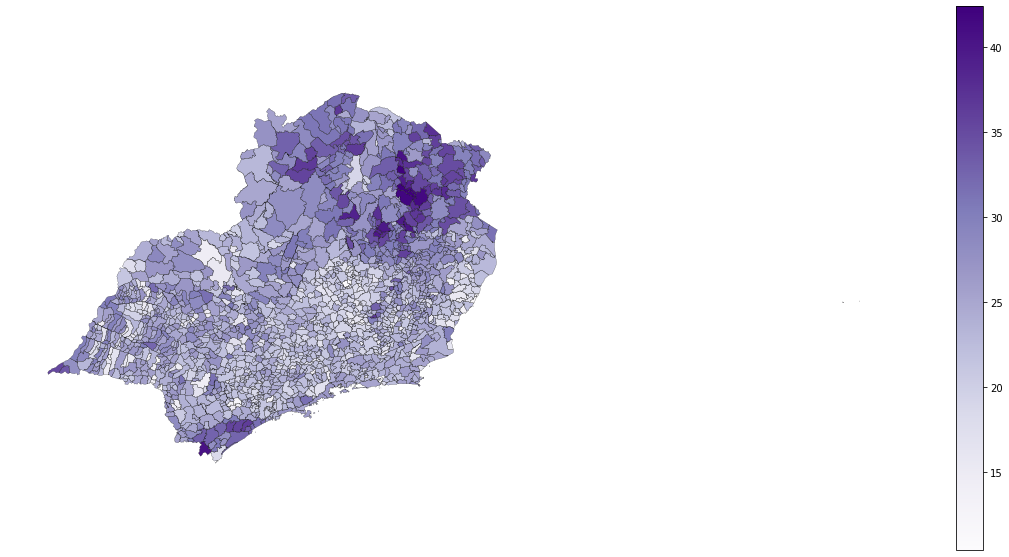

In [250]:
# proporçao abstencao 1º turno
municipio_geometry_sudeste_gpd['proporcao_abstencao'] = 100 - municipio_geometry_sudeste_gpd['proporcao_comparecimento']

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt1].plot(column = 'proporcao_abstencao',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples'
                                        )
ax.set_axis_off()
plt.show()

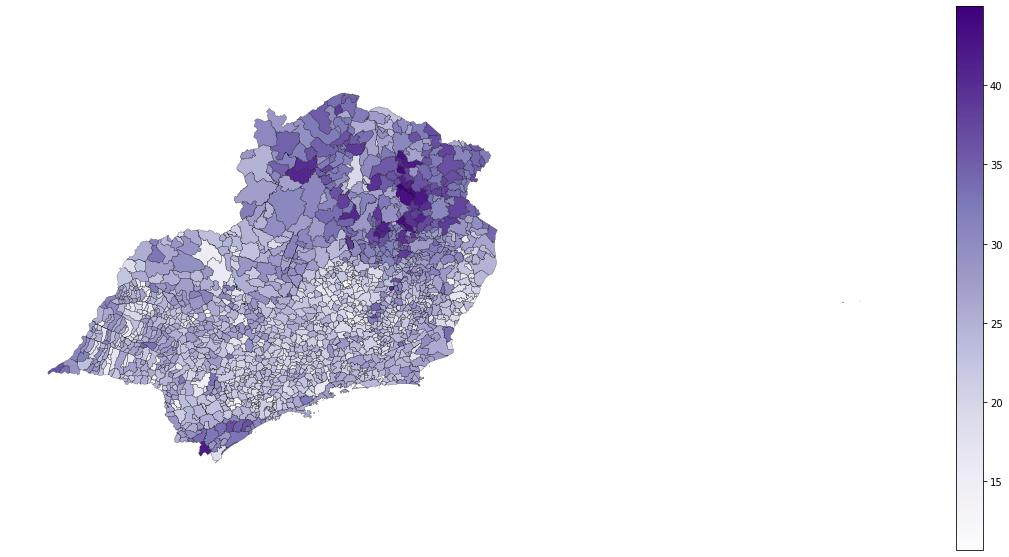

In [251]:
# proporçao abstencao 2º turno
municipio_geometry_sudeste_gpd['proporcao_abstencao'] = 100 - municipio_geometry_sudeste_gpd['proporcao_comparecimento']

fig, ax = plt.subplots(1, figsize=(20, 20))
ax2 = municipio_geometry_sudeste_gpd.boundary.plot(figsize = (20,20), edgecolor = 'k', linewidth = 0.1, ax = ax)
ax = municipio_geometry_sudeste_gpd[flt2].plot(column = 'proporcao_abstencao',
                                        categorical = False,
                                        legend = True,
                                        figsize = (20,20),
                                        ax = ax,
                                        legend_kwds={'shrink': 0.5},
                                        cmap = 'Purples'
                                        )
ax.set_axis_off()
plt.show()

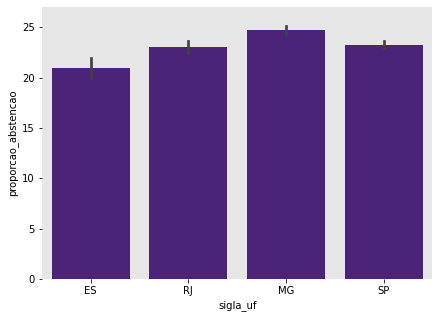

In [252]:
# proporcao abstencoes 1º turno

# get rows where cargo is "PRESIDENTE" and id_municipio is not null
election_2018 = detalhes_votacao_municipio.query("cargo == 'presidente' & ano == 2018 & sigla_uf != 'ZZ'",)

# get only id_municipio, sigla_uf, votos_validos, votos_brancos, votos_nulos, proporcao_votos_brancos, proporcao_votos_nulos
election_2018 = election_2018[['id_municipio', 'sigla_uf', 'comparecimento', 'abstencoes', 'turno', 'proporcao_comparecimento']]
election_2018 = election_2018.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG'] & turno == 1")
election_2018['proporcao_abstencao'] = 100 - election_2018['proporcao_comparecimento']


# do the same with purple color
fig, ax = plt.subplots(1, figsize=(7, 5))
ax.set_ylim(0, 27)
ax.set_facecolor('#E6E6E6')
sns.barplot(x = 'sigla_uf', y = 'proporcao_abstencao', data = election_2018, ax = ax, color = '#4A1587')
sns.despine(left=True, bottom=True)

plt.show()

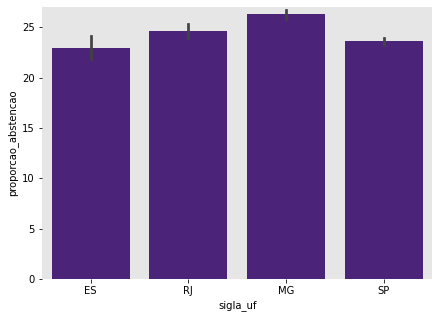

In [253]:
# proporcao abstencoes 2º turno

# get rows where cargo is "PRESIDENTE" and id_municipio is not null
election_2018 = detalhes_votacao_municipio.query("cargo == 'presidente' & ano == 2018 & sigla_uf != 'ZZ'",)

# get only id_municipio, sigla_uf, votos_validos, votos_brancos, votos_nulos, proporcao_votos_brancos, proporcao_votos_nulos
election_2018 = election_2018[['id_municipio', 'sigla_uf', 'comparecimento', 'abstencoes', 'turno', 'proporcao_comparecimento']]
election_2018 = election_2018.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG'] & turno == 2")
election_2018['proporcao_abstencao'] = 100 - election_2018['proporcao_comparecimento']

fig, ax = plt.subplots(1, figsize=(7, 5))
ax.set_ylim(0, 27)
ax.set_facecolor('#E6E6E6')
sns.barplot(x = 'sigla_uf', y = 'proporcao_abstencao', data = election_2018, ax = ax, color = '#4A1587')
sns.despine(left=True, bottom=True)

plt.show()

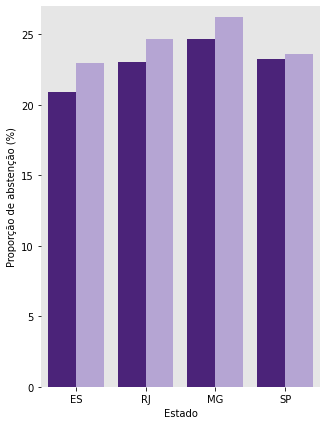

In [254]:
# make barplot of abstencao by state of 1st and 2nd turn

# get rows where cargo is "PRESIDENTE" and id_municipio is not null
election_2018 = detalhes_votacao_municipio.query("cargo == 'presidente' & ano == 2018 & sigla_uf != 'ZZ'",)
election_2018 = election_2018.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG']")
election_2018['proporcao_abstencao'] = 100 - election_2018['proporcao_comparecimento']

fig, ax = plt.subplots(1, figsize=(5, 7))
ax.set_ylim(0, 27)
ax.set_facecolor('#E6E6E6')
sns.barplot(x = 'sigla_uf', y = 'proporcao_abstencao', data = election_2018, ax = ax, hue = 'turno', palette = ['#4A1587', '#B39DDB'], ci=None)
sns.despine(left=True, bottom=True)

# set axis labels
ax.set_xlabel('Estado')
ax.set_ylabel('Proporção de abstenção (%)')

# remove legend 
ax.get_legend().remove()

plt.show()

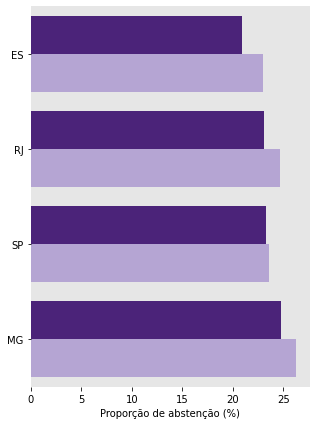

In [255]:
# make horizontal barplot of abstencao by state of 1st and 2nd turn

# get rows where cargo is "PRESIDENTE" and id_municipio is not null
election_2018 = detalhes_votacao_municipio.query("cargo == 'presidente' & ano == 2018 & sigla_uf != 'ZZ'",)
election_2018 = election_2018.query("sigla_uf in ['RJ', 'SP', 'ES', 'MG']")
election_2018['proporcao_abstencao'] = 100 - election_2018['proporcao_comparecimento']

fig, ax = plt.subplots(1, figsize=(5, 7))
ax.set_ylim(0, 27)
ax.set_facecolor('#E6E6E6')
sns.barplot(x = 'proporcao_abstencao', y = 'sigla_uf', data = election_2018, ax = ax, hue = 'turno', palette = ['#4A1587', '#B39DDB'], ci=None, order = ['ES', 'RJ', 'SP', 'MG'])
sns.despine(left=True, bottom=True)

# set axis labels
ax.set_xlabel('Proporção de abstenção (%)')
ax.set_ylabel('')

# remove legend
ax.get_legend().remove()

plt.show()

## Análise Espiríto Santo resultado


In [289]:

query = """
SELECT *
FROM basedosdados.br_tse_eleicoes.resultados_candidato_municipio
WHERE ano in (2018) AND sigla_uf in ('ES') AND cargo in ('presidente') AND turno in (1)
"""

resultados_candidato_municipio = bd.read_sql(query, 
                                billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 1014/1014 [00:00<00:00, 2718.73rows/s]


In [290]:
resultados_candidato_municipio.head()

,ano,turno,tipo_eleicao,sigla_uf,id_municipio,id_municipio_tse,cargo,numero_partido,sigla_partido,numero_candidato,sequencial_candidato,id_candidato_bd,resultado,votos
0,2018,1,eleicao ordinaria,ES,3200102,56014,presidente,12,PDT,12,280000605589,1391775,nao eleito,1227
1,2018,1,eleicao ordinaria,ES,3200102,56014,presidente,13,PT,13,280000629808,1100069,2º turno,4382
2,2018,1,eleicao ordinaria,ES,3200102,56014,presidente,15,MDB,15,280000622281,1704038,nao eleito,210
3,2018,1,eleicao ordinaria,ES,3200102,56014,presidente,16,PSTU,16,280000601173,27173,nao eleito,5
4,2018,1,eleicao ordinaria,ES,3200102,56014,presidente,17,PSL,17,280000614517,226196,2º turno,9000


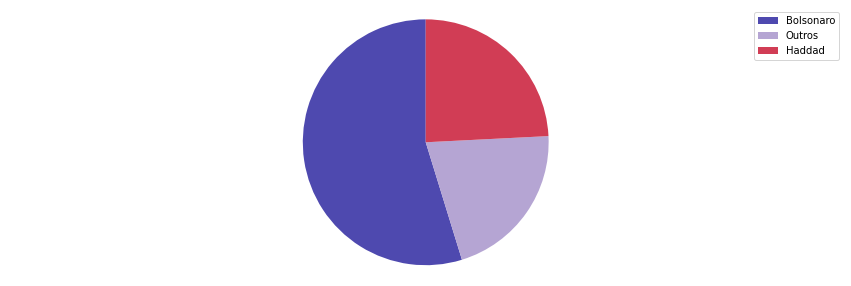

In [310]:
# do pie chart of votes by candidate at 1st turn

# make all numero_candidato not in ['13', '17'] to 'outros'
resultados_candidato_municipio.loc[~resultados_candidato_municipio['numero_candidato'].isin(['13', '17']), 'numero_candidato'] = '14'

# group by numero_candidate and sum votos
resultados_candidato_municipio = resultados_candidato_municipio.groupby(['numero_candidato']).sum().reset_index()

# sort by votos in descending order
resultados_candidato_municipio = resultados_candidato_municipio.sort_values(by=['numero_candidato'], ascending=False)

# do  pie chart
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.set_facecolor('#E6E6E6')
ax.pie(resultados_candidato_municipio['votos'], startangle=90,  colors = ['#4E49AF','#B5A5D3','#D13D55'])
ax.axis('equal')
sns.despine(left=True, bottom=True)

# show legend
plt.legend(labels = ['Bolsonaro', 'Outros', 'Haddad'], loc = 'upper right')

plt.show()

In [288]:

query = """
SELECT *
FROM basedosdados.br_tse_eleicoes.resultados_candidato_municipio
WHERE ano in (2018) AND sigla_uf in ('ES') AND cargo in ('presidente') AND turno in (2)
"""

resultados_candidato_municipio = bd.read_sql(query, 
                                billing_project_id="brazilian-elections-2022")

Downloading: 100%|██████████| 156/156 [00:00<00:00, 417.81rows/s]


In [ ]:
# do pie chart of votes by candidate at 1st turn

# make all numero_candidato not in ['13', '17'] to 'outros'
resultados_candidato_municipio.loc[~resultados_candidato_municipio['numero_candidato'].isin(['13', '17']), 'numero_candidato'] = '14'

# group by numero_candidate and sum votos
resultados_candidato_municipio = resultados_candidato_municipio.groupby(['numero_candidato']).sum().reset_index()

# sort by votos in descending order
resultados_candidato_municipio = resultados_candidato_municipio.sort_values(by=['votos'], ascending=False)

# do  pie chart
fig, ax = plt.subplots(1, figsize=(5, 5))
ax.set_facecolor('#E6E6E6')
ax.pie(resultados_candidato_municipio['votos'], startangle=90, colors=['#4E49AF','#D13D55'])
ax.axis('equal')
sns.despine(left=True, bottom=True)

plt.show()